In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import skew, norm, probplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error,root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load database

In [407]:
# Load database
project_dir = Path.cwd() 
data_path = project_dir.parent / "data"
df = pd.read_csv( data_path / 'real_estate_belguim.csv', sep=',') 

In [408]:
# Count numerical features and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude=["object"]).drop("price", axis=1).columns

print("Numerical features: " + str(len(numerical_features)))
print("Categorical features: " + str(len(categorical_features)))

Numerical features: 4
Categorical features: 0


In [409]:
df

,price,living_area,median_price_per_municipality,prosperity_index,extra_investment
0,148000.0,149.0,180625.0,91.0,4
1,225000.0,61.0,225000.0,107.0,3
2,445000.0,105.0,405000.0,111.0,3
3,269000.0,72.0,285000.0,87.0,3
4,465000.0,93.0,243000.0,102.0,5
...,...,...,...,...,...
18203,235000.0,98.0,189250.0,83.0,4
18204,280000.0,80.0,248500.0,105.0,5
18205,350000.0,56.0,324062.5,70.0,4
18206,350000.0,56.0,441875.0,83.0,4


***

# Get matrics class

In [410]:
class Get_Regression_Metrics:
    """
    A class to compute and display regression evaluation metrics for 
    both training and testing datasets.
    
    Metrics included:
    - Mean Absolute Error (MAE)
    - Root Mean Square Error (RMSE)
    - R² (Coefficient of Determination)
    - Mean Absolute Percentage Error (MAPE)
    - Symmetrical Mean Absolute Percentage Error (sMAPE)
    """
    def __init__(self, y_train, y_train_pred, y_test, y_test_pred):
        """
        Initializes Get_Regression_Metrics class with a actual and predicted values for test and train.
        :param y_train: Actual target values for the training set.
        :param y_train_pred: Predicted target values for the training set.
        :param y_test: Actual target values for the testing set.
        :param y_test_pred: Predicted target values for the testing set.
        """
        self.y_train = y_train
        self.y_train_pred = y_train_pred
        self.y_test = y_test
        self.y_test_pred = y_test_pred

    def get_mae(self):
        """
        Mean absolute error (MAE) is an average of the absolute errors.
        MAE is always greater than or equal to 0 and MAE value 0 represents perfect fit.
        The MAE units are the same as the predicted target.  
        """
        self.mae_train = mean_absolute_error(self.y_train, self.y_train_pred)
        self.mae_test = mean_absolute_error(self.y_test, self.y_test_pred)
        print(f"MAE(train): {self.mae_train:.3f}")
        print(f"MAE(test): {self.mae_test:.3f}")

    def get_rmse(self):
        """
        Root Mean Square Error (RMSE) represents the square root of the variance of the residuals.
        The smaller the RMSE, the closer your model's predictions are to reality.
        RMSE is expressed in the same unit as the predicted values 
        """ 
        self.rmse_train = root_mean_squared_error(self.y_train, self.y_train_pred)
        self.rmse_test = root_mean_squared_error(self.y_test, self.y_test_pred)
        print(f"RMSE(train): {self.rmse_train:.3f}")
        print(f"RMSE(test): {self.rmse_test:.3f}")

    def get_r2(self):
        """
        R² (coefficient of determination) regression score function.
        R² is an element of [0, 1].
        Best possible score is 1.0 and it can be negative (the model can be arbitrarily worse).
        """
        self.r2_train = r2_score(self.y_train, self.y_train_pred)
        self.r2_test = r2_score(self.y_test, self.y_test_pred)
        print(f"R²(train): {self.r2_train:.3f}")
        print(f"R²(test): {self.r2_test:.3f}")

    def get_mape(self):
        """
        Mean absolute percentage error (MAPE) regression loss. 
        It measures accuracy as a percentage.
        Lower values of MAPE indicate higher accuracy.
        """
        self.mape_train = mean_absolute_percentage_error(self.y_train, self.y_train_pred)
        self.mape_test = mean_absolute_percentage_error(self.y_test, self.y_test_pred)
        print(f"MAPE (train): {self.mape_train:.3f}")
        print(f"MAPE (test): {self.mape_test:.3f}")

    def get_smape(self):
        """
        Symmetrical mean absolute percentage error (sMAPE) 
        is an accuracy measure based on percentage (or relative) errors.
        The resulting score ranges between 0 and 1, where a score of 0 indicates a perfect match. 
        """
        def smape(actual, forecast):
            actual = np.array(actual)
            forecast = np.array(forecast)
            smape = np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))) * 100
            return smape
        self.smape_train = smape(self.y_train, self.y_train_pred)
        self.smape_test = smape(self.y_test, self.y_test_pred)
        print(f"sMAPE (train): {self.smape_train:.3f}")
        print(f"sMAPE (test): {self.smape_test:.3f}")

    def get_all_metrics(self):
        """
        Get all the metrics.
        """
        self.get_mae()
        self.get_rmse()
        self.get_r2()
        self.get_mape()
        self.get_smape()

***

# Models

In [411]:
# Splitting data into test and train | 20/80 ratio
X = df.drop('price', axis=1)
y = np.sqrt(df['price'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=355)

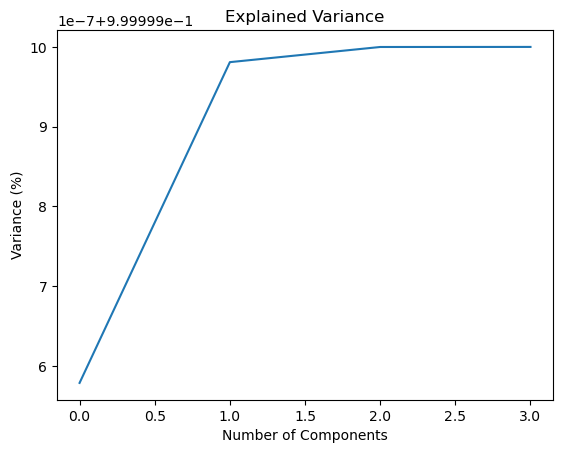

In [412]:
pca = PCA()
principalComponents = pca.fit_transform(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

The variance appears to be primarily explained by the feature 'living_area'. 

***

#### Decision tree

In [413]:
# Decision Tree Regression model
dt_regressor_1 = DecisionTreeRegressor(random_state=100, min_samples_split=15, min_samples_leaf=10, max_leaf_nodes=150, max_depth=20) 
dt_regressor_1.fit(X_train,y_train)

# Predictions 
y_train_pred_1 = dt_regressor_1.predict(X_train)
y_test_pred_1 = dt_regressor_1.predict(X_test)

# Original scale (squared) 
y_train_pred_original = y_train_pred_1  ** 2
y_test_pred_original = y_test_pred_1 ** 2
y_train_original = y_train ** 2
y_test_original = y_test ** 2

# Get metrics
metrics_tr_regressor = Get_Regression_Metrics(
    y_train_original, y_train_pred_original, 
    y_test_original, y_test_pred_original
)
metrics_tr_regressor.get_all_metrics()

MAE(train): 63736.119
MAE(test): 67076.233
RMSE(train): 84991.672
RMSE(test): 89955.354
R²(train): 0.585
R²(test): 0.542
MAPE (train): 0.225
MAPE (test): 0.230
sMAPE (train): 41.671
sMAPE (test): 41.597


In [ ]:
# Actual values vs predicted values and difference
y_test_original = y_test_original.ravel() if len(y_test_original.shape) > 1 else y_test_original
y_test_pred_original = y_test_pred_original.ravel() if len(y_test_pred_original.shape) > 1 else y_test_pred_original

pred_y2_df = pd.DataFrame({
    'Actual Values': y_test_original,
    'Predicted Value': y_test_pred_original,
    'Difference': y_test_original - y_test_pred_original
})

pred_y2_df = pred_y2_df.round(2)
print(pred_y2_df.head(20))

    Actual Values  Predicted Value  Difference
0        359000.0        375254.87   -16254.87
1        285000.0        286697.95    -1697.95
2        379500.0        299510.72    79989.28
3        279000.0        259092.97    19907.03
4        649000.0        571142.32    77857.68
5        275000.0        299510.72   -24510.72
6        176000.0        145484.52    30515.48
7        139000.0        164565.95   -25565.95
8        560000.0        448496.47   111503.53
9        269000.0        308195.16   -39195.16
10       330000.0        354211.69   -24211.69
11       499000.0        571142.32   -72142.32
12       435000.0        453149.82   -18149.82
13       329000.0        286697.95    42302.05
14       259000.0        310717.35   -51717.35
15       145000.0        164565.95   -19565.95
16       164000.0        260933.60   -96933.60
17       429000.0        368230.21    60769.79
18       159000.0        165189.77    -6189.77
19       299000.0        331831.13   -32831.13


***

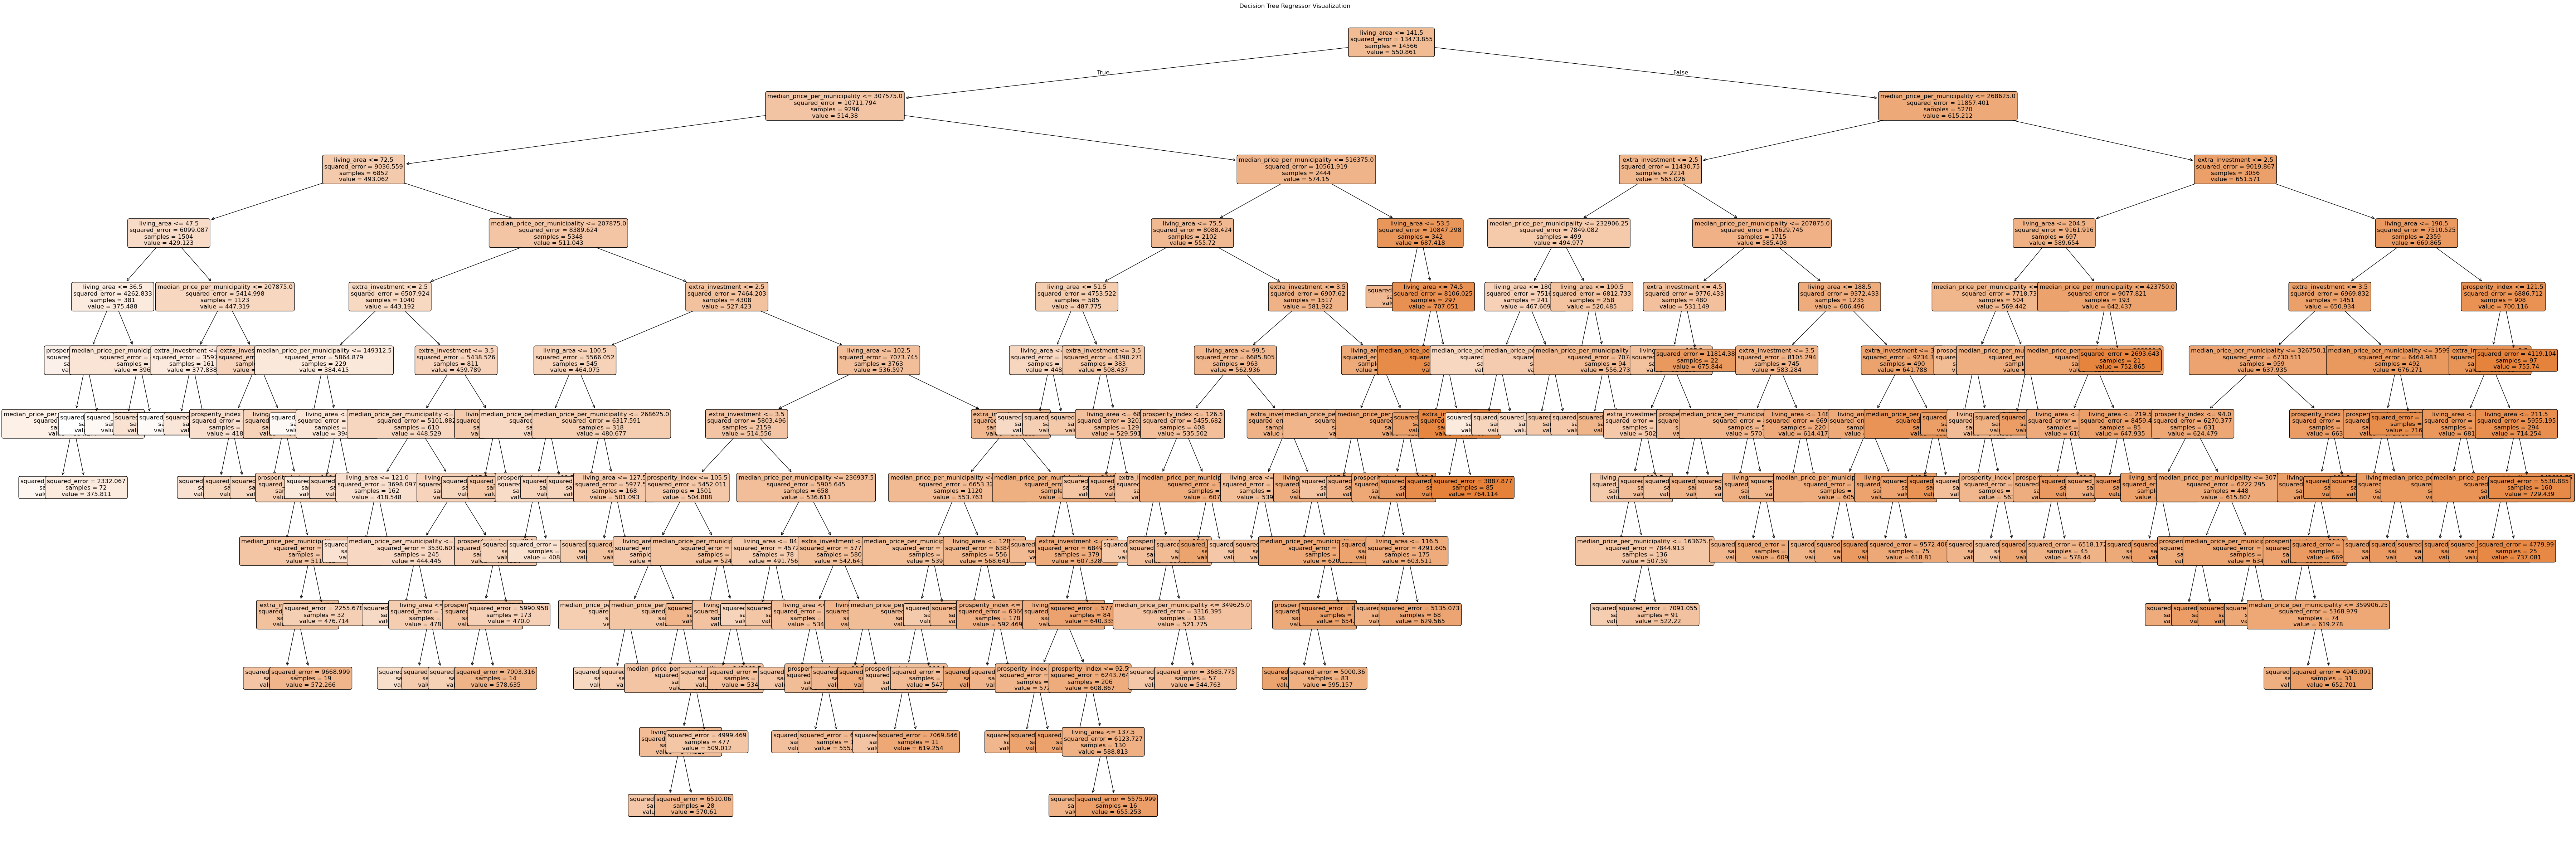

In [415]:
# Plot the decision tree
plt.figure(figsize=(90, 30)) 
plot_tree(dt_regressor_1, 
          filled=True, 
          feature_names=X_train.columns,
          rounded=True, 
          fontsize=12)
plt.title('Decision Tree Regressor Visualization')
plt.show()

***

DecisionTreeRegressor with all features. 
* SQRT transformation to targe ('price'): It is also used for reducing right skewness (high values get compressed and low values become more spread out). Before computing metrics, the predictions and actual values need to be transformed back to the original scale by squaring them.
* RobustScaler(): Scale features using statistics that are robust to outliers. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
* Hyperparameter Tuning with RandomizedSearchCV: using 100 random combinations and 10-fold cross-validation.

Best Parameters: {'model__min_samples_split': 45, 'model__min_samples_leaf': 16, 'model__max_leaf_nodes': 192, 'model__max_depth': 42}
Cross-Validation Mean MSE: 5944.51
Cross-Validation Std MSE: 338.99


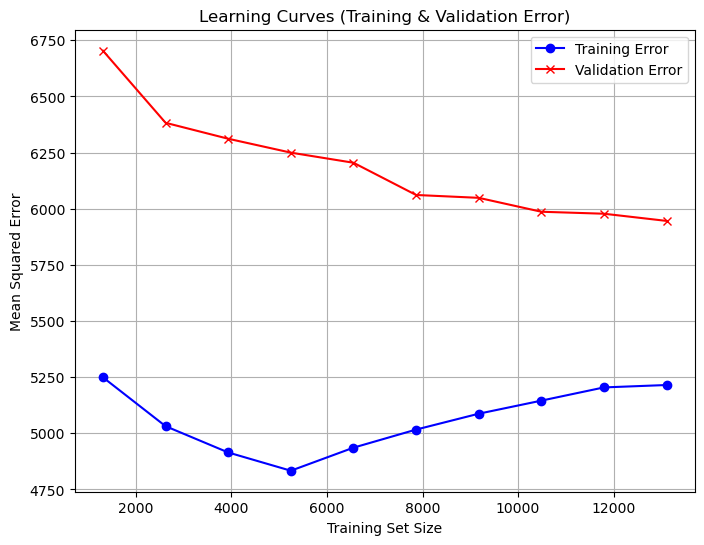

MAE(train): 63091.198
MAE(test): 67001.760
RMSE(train): 84145.832
RMSE(test): 89693.285
R²(train): 0.594
R²(test): 0.545
MAPE (train): 0.223
MAPE (test): 0.230
sMAPE (train): 41.757
sMAPE (test): 41.660


In [416]:
# Preprocessing pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),          
    ('model', DecisionTreeRegressor(random_state=100))  
])

# RandomizedSearchCV with 10-Fold Cross Validation
param_distributions = {
    'model__max_depth': range(2, 100),
    'model__max_leaf_nodes': range(2, 200, 5),
    'model__min_samples_split': range(2, 50),
    'model__min_samples_leaf': range(1, 50),
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',  
    cv=10,  
    n_iter=100,  
    random_state=42,
    n_jobs=-1
)

# Search best parameters with RandomizedSearchCV
random_search.fit(X_train, y_train)
best_pipeline = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# 10-Fold Cross Validation 
cv_scores = cross_val_score(
    best_pipeline, X_train, y_train, 
    cv=10,  
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

mean_cv_score = np.mean(-cv_scores)  
std_cv_score = np.std(-cv_scores)
print(f"Cross-Validation Mean MSE: {mean_cv_score:.2f}")
print(f"Cross-Validation Std MSE: {std_cv_score:.2f}")

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

train_errors = -train_scores.mean(axis=1)  
val_errors = -val_scores.mean(axis=1) 

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, label='Training Error', color='blue', linestyle='-', marker='o')
plt.plot(train_sizes, val_errors, label='Validation Error', color='red', linestyle='-', marker='x')
plt.title('Learning Curves (Training & Validation Error)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Predictions 
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Original scale (squared) 
y_train_pred_original = y_train_pred ** 2
y_test_pred_original = y_test_pred ** 2
y_train_original = y_train ** 2
y_test_original = y_test ** 2

# Get metrics
metrics_tr_regressor = Get_Regression_Metrics(
    y_train_original, y_train_pred_original, 
    y_test_original, y_test_pred_original
)
metrics_tr_regressor.get_all_metrics()

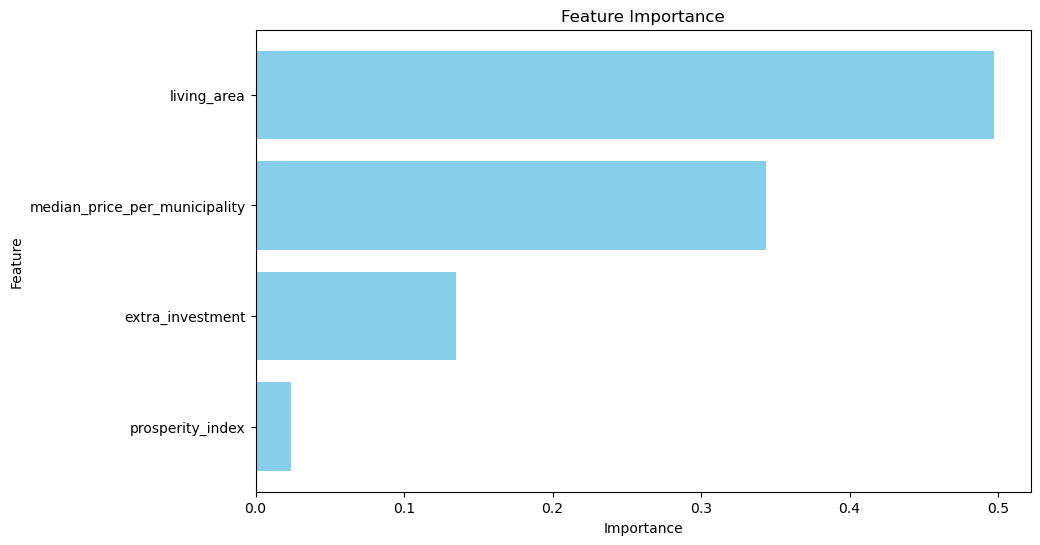

In [417]:
# Feature importance 
feature_importance = best_pipeline.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

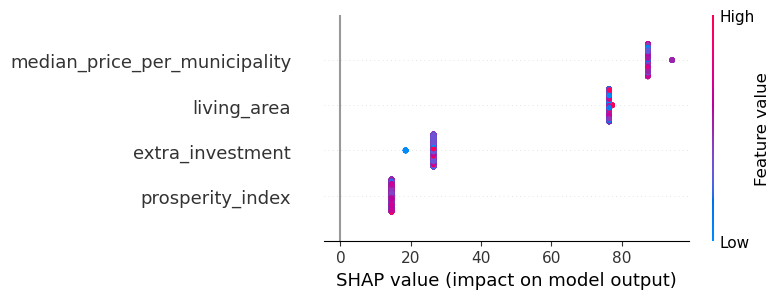

In [418]:
# SHAP TreeExplainer for RandomForest
best_model = random_search.best_estimator_
model = best_model.named_steps['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

***

Best Parameters: {'model__min_samples_split': 45, 'model__min_samples_leaf': 16, 'model__max_leaf_nodes': 192, 'model__max_depth': 42}
Cross-Validation Mean MSE: 5944.34
Cross-Validation Std MSE: 339.37


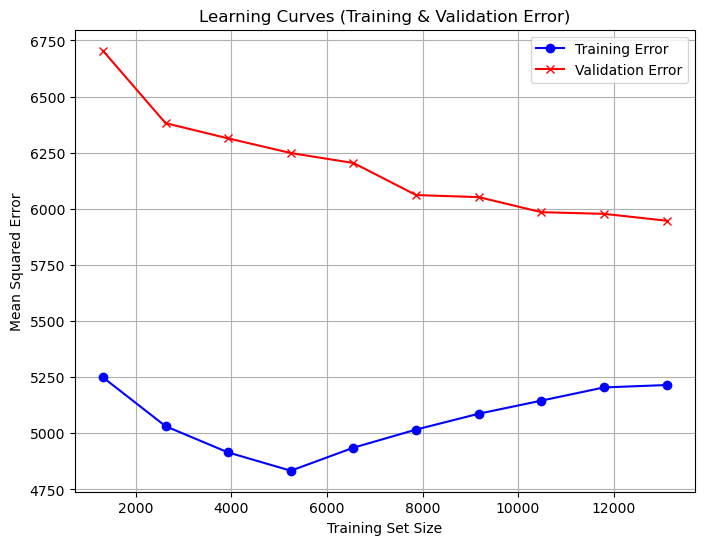

MAE(train): 63091.198
MAE(test): 67001.760
RMSE(train): 84145.832
RMSE(test): 89693.285
R²(train): 0.594
R²(test): 0.545
MAPE (train): 0.223
MAPE (test): 0.230
sMAPE (train): 41.757
sMAPE (test): 41.660


In [419]:
# Preprocessing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),          
    ('model', DecisionTreeRegressor(random_state=100))  
])

# RandomizedSearchCV with 10-Fold Cross Validation
param_distributions = {
    'model__max_depth': range(2, 100),
    'model__max_leaf_nodes': range(2, 200, 5),
    'model__min_samples_split': range(2, 50),
    'model__min_samples_leaf': range(1, 50),
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',  
    cv=10,  
    n_iter=100,  
    random_state=42,
    n_jobs=-1
)

# Search best parameters with RandomizedSearchCV
random_search.fit(X_train, y_train)
best_pipeline = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Perform 5-Fold Cross Validationon on the best pipeline
cv_scores = cross_val_score(
    best_pipeline, X_train, y_train, 
    cv=10,  
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

mean_cv_score = np.mean(-cv_scores)  
std_cv_score = np.std(-cv_scores)
print(f"Cross-Validation Mean MSE: {mean_cv_score:.2f}")
print(f"Cross-Validation Std MSE: {std_cv_score:.2f}")

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# Compute the mean and std of the training and validation scores
train_errors = -train_scores.mean(axis=1)  
val_errors = -val_scores.mean(axis=1) 

# Plotting the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, label='Training Error', color='blue', linestyle='-', marker='o')
plt.plot(train_sizes, val_errors, label='Validation Error', color='red', linestyle='-', marker='x')
plt.title('Learning Curves (Training & Validation Error)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Predictions on train and test sets
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Transform back to the original scale (squared)
y_train_pred_original = y_train_pred ** 2
y_test_pred_original = y_test_pred ** 2
y_train_original = y_train ** 2
y_test_original = y_test ** 2

# Get metrics
metrics_tr_regressor = Get_Regression_Metrics(
    y_train_original, y_train_pred_original, 
    y_test_original, y_test_pred_original
)
metrics_tr_regressor.get_all_metrics()

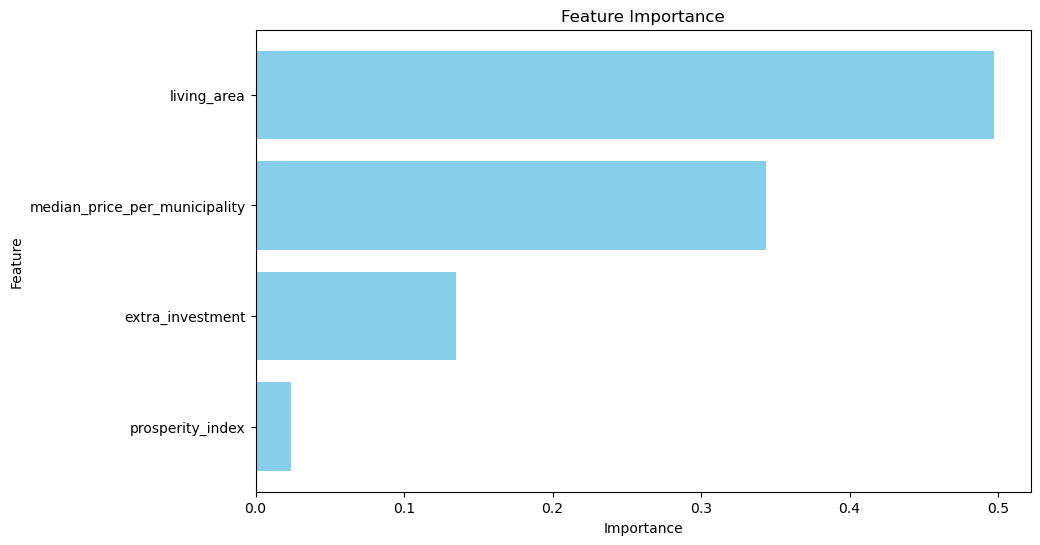

In [420]:
# Feature importance 
feature_importance = best_pipeline.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

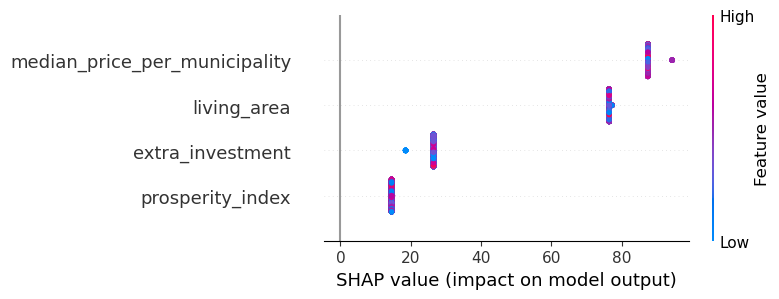

In [421]:
# SHAP TreeExplainer for RandomForest
best_model = random_search.best_estimator_
model = best_model.named_steps['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

***

#### Random Forest Regression Model

In [423]:
# Splitting data into train and test 20/80
drop_columns = ['price']
X_2features = df.drop(drop_columns, axis=1)
y_2features = np.sqrt(df['price'].values.reshape(-1,1))

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2features, y_2features, test_size=0.2, random_state=450)


# Decision Tree Regression model 
dt_regressor_2 = RandomForestRegressor(random_state=100, n_estimators=150, min_samples_split=100, min_samples_leaf=17, max_leaf_nodes=100, max_depth=100, bootstrap=True) 
dt_regressor_2.fit(X_train_2,y_train_2)


# Predictions 
y_train_pred_2 = dt_regressor_2.predict(X_train_2)
y_test_pred_2 = dt_regressor_2.predict(X_test_2)

# Original scale (squared) 
y_train_pred_2_original = y_train_pred_2  ** 2
y_test_pred_2_original = y_test_pred_2 ** 2
y_train_2_original = y_train_2 ** 2
y_test_2_original = y_test_2 ** 2

# Get metrics
metrics_tr_regressor = Get_Regression_Metrics(
    y_train_2_original, y_train_pred_2_original, 
    y_test_2_original, y_test_pred_2_original
)
metrics_tr_regressor.get_all_metrics()

/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MAE(train): 63215.214
MAE(test): 64943.569
RMSE(train): 84783.676
RMSE(test): 87424.745
R²(train): 0.588
R²(test): 0.567
MAPE (train): 0.222
MAPE (test): 0.237
sMAPE (train): 41.158
sMAPE (test): 41.336


In [424]:
# Actual values vs predicted values and  difference
y_test_2_original = y_test_2_original.ravel() if len(y_test_2_original.shape) > 1 else y_test_original
y_test_pred_2_original = y_test_pred_2_original.ravel() if len(y_test_pred_2_original.shape) > 1 else y_test_pred_2_original

pred_y_df = pd.DataFrame({
    'Actual Values': y_test_2_original,
    'Predicted Value': y_test_pred_2_original,
    'Difference': y_test_2_original - y_test_pred_2_original
})

pred_y_df = pred_y_df.round(2)
print(pred_y_df.head(20))

    Actual Values  Predicted Value  Difference
0        249000.0        223788.48    25211.52
1        224000.0        226212.01    -2212.01
2        325000.0        218385.74   106614.26
3        269000.0        157307.02   111692.98
4        275000.0        306627.77   -31627.77
5        260000.0        232490.61    27509.39
6        299000.0        355542.12   -56542.12
7        169000.0        129814.25    39185.75
8        299000.0        299660.94     -660.94
9        318000.0        387115.80   -69115.80
10       245000.0        385057.66  -140057.66
11       374690.0        368591.83     6098.17
12       319000.0        496044.00  -177044.00
13       286500.0        276019.66    10480.34
14       275000.0        288496.14   -13496.14
15       349000.0        299007.10    49992.90
16       339000.0        253486.39    85513.61
17       330000.0        422858.07   -92858.07
18       180000.0        247058.64   -67058.64
19       370000.0        244278.84   125721.16


In [425]:
# Preprocessing pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),        
    ('model', RandomForestRegressor(random_state=100)) 
])

# RandomizedSearchCV with 5-Fold Cross Validation
param_distributions = {
    'model__n_estimators': [100, 110, 150,200], 
    'model__max_depth': range(5, 100), 
    'model__min_samples_split': range(2, 100),  
    'model__min_samples_leaf': range(1, 100),  
}

# RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error', 
    cv=5, 
    n_iter=100, 
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train.ravel())  

# Best pipeline after search
best_pipeline = random_search.best_estimator_

# Print best parameters
print("Best Parameters:", random_search.best_params_)

# Perform cross-validation on the best pipeline
cv_scores = cross_val_score(
    best_pipeline, X_train, y_train, 
    cv=5,  # 5-Fold Cross Validation
    scoring='neg_mean_squared_error',  # Use Negative MSE
    n_jobs=-1
)

# Compute the mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(-cv_scores)  # Convert to positive MSE
std_cv_score = np.std(-cv_scores)

print(f"Cross-Validation Mean MSE: {mean_cv_score:.2f}")
print(f"Cross-Validation Std MSE: {std_cv_score:.2f}")

# Predictions on train and test sets
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Transform back to the original scale (squared)
y_train_pred_original = y_train_pred ** 2
y_test_pred_original = y_test_pred ** 2
y_train_original = y_train ** 2
y_test_original = y_test ** 2

# Evaluate metrics
metrics_tr_regressor = Get_Regression_Metrics(
    y_train_original, y_train_pred_original, 
    y_test_original, y_test_pred_original
)
metrics_tr_regressor.get_all_metrics()

Best Parameters: {'model__n_estimators': 110, 'model__min_samples_split': 42, 'model__min_samples_leaf': 4, 'model__max_depth': 77}


/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d a

Cross-Validation Mean MSE: 5524.35
Cross-Validation Std MSE: 196.64
MAE(train): 57878.950
MAE(test): 64190.052
RMSE(train): 78074.129
RMSE(test): 86688.490
R²(train): 0.650
R²(test): 0.575
MAPE (train): 0.204
MAPE (test): 0.221
sMAPE (train): 41.719
sMAPE (test): 41.572


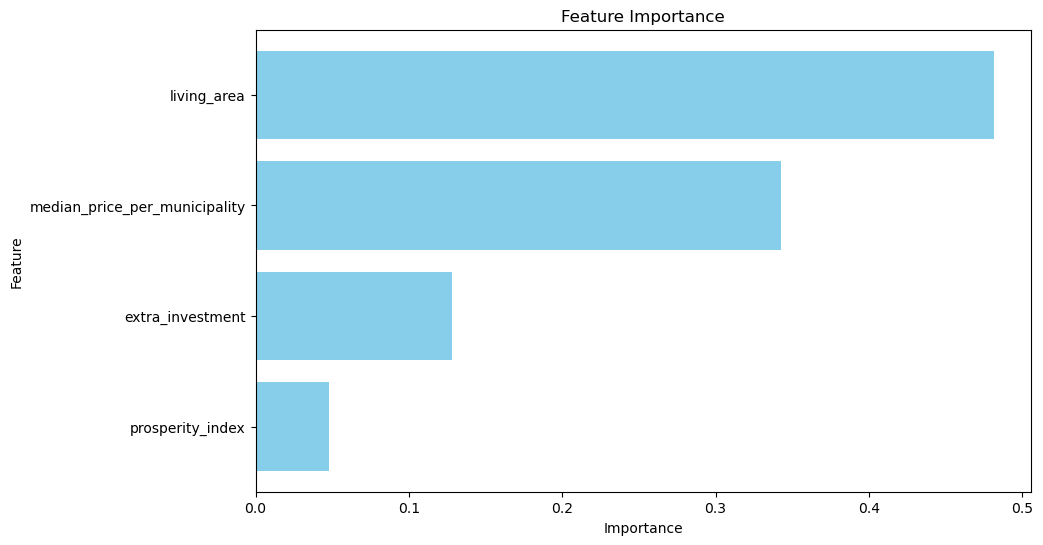

In [426]:
# Feature importance 
feature_importance = best_pipeline.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

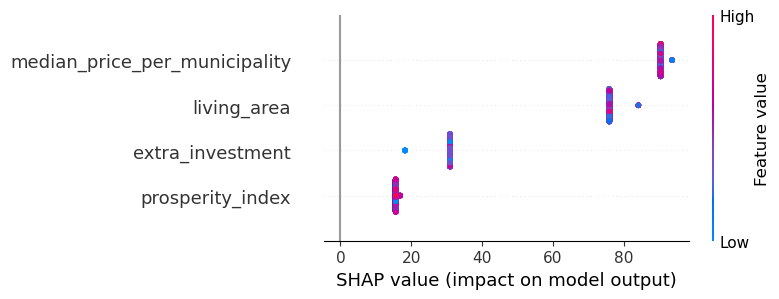

In [427]:
# SHAP TreeExplainer for RandomForest
best_model = random_search.best_estimator_
model = best_model.named_steps['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [428]:
# Actual values vs predicted values and  difference
y_test_original = y_test_original.ravel() if len(y_test_original.shape) > 1 else y_test_original
y_test_pred_original = y_test_pred_original.ravel() if len(y_test_pred_original.shape) > 1 else y_test_pred_original

pred_y_df = pd.DataFrame({
    'Actual Values': y_test_original,
    'Predicted Value': y_test_pred_original,
    'Difference': y_test_original - y_test_pred_original
})

pred_y_df = pred_y_df.round(2)
print(pred_y_df.head(20))

    Actual Values  Predicted Value  Difference
0        359000.0        366934.27    -7934.27
1        285000.0        299898.99   -14898.99
2        379500.0        281476.58    98023.42
3        279000.0        260052.93    18947.07
4        649000.0        568214.78    80785.22
5        275000.0        301939.73   -26939.73
6        176000.0        152477.85    23522.15
7        139000.0        139469.05     -469.05
8        560000.0        466991.12    93008.88
9        269000.0        276892.91    -7892.91
10       330000.0        341925.63   -11925.63
11       499000.0        588623.82   -89623.82
12       435000.0        424403.10    10596.90
13       329000.0        321695.28     7304.72
14       259000.0        337632.22   -78632.22
15       145000.0        196330.85   -51330.85
16       164000.0        292271.43  -128271.43
17       429000.0        346783.86    82216.14
18       159000.0        181049.06   -22049.06
19       299000.0        306016.57    -7016.57


***